This notebook contains code to generate plots of the PCA representations

In [1]:
from tqdm.notebook import tqdm
import time
import struct
import pickle
import os

import numpy as np

import gymnasium as gym
import miniworld

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import FastICA, PCA

from scipy.signal import convolve
from scipy.stats import norm

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import Normalize
import matplotlib as mpl
from matplotlib.transforms import Affine2D

In [2]:
os.makedirs('../images/', exist_ok=True)

In [3]:
def collect_data(env, num_steps = 10000, mode="syst", noise=0.7):
    """
    Data should be required on "MiniWorld-StarMaze-v0" since this doesn't have a goal (i.e. box) in it.
    Args:
        num_steps (int): How many observations to gather
        mode (str): Which collection procedure to apply. Valid are "rand" for random, "systematic" for walking along the right wall,
                    "syst_rand" for a mixture of both
    """
    # Actions are 0 (turn left), 1 (turn right), 2 (move forward)
    observations = np.zeros((num_steps, 60, 80, 3))
    positions = np.zeros((num_steps, 3))
    actions = np.zeros((num_steps))
    directions = np.zeros((num_steps))
    i = 0
    pbar = tqdm(total=num_steps)
    while i < num_steps:
        match mode:
            case "rand":
                obs, acts, pos, rot = _rand_action(env)
            case "syst":
                obs, acts, pos, rot = _syst_action(env)
            case "syst_rand":
                obs, acts, pos, rot = _syst_rand_action(env, noise)
        if i+len(obs) > num_steps: # Potentially crop if num_steps is reached
            obs = obs[:num_steps-i]
            acts = acts[:num_steps-i]
            pos = pos[:num_steps-i]
            rot = rot[:num_steps-i]
        observations[i:i+len(obs)] = obs
        actions[i:i+len(acts)] = acts
        positions[i:i+len(pos)] = pos
        directions[i:i+len(rot)] = rot
        i += len(obs)
        pbar.update(len(obs))
    pbar.close()
    return observations, positions, actions, np.round(directions%(2*np.pi), 4) # Sort out multiples of direction beyond 2pi

def _rand_action(env):
    action = env.action_space.sample()
    obs, _, _, _, _ = env.step(action)
    return [obs], [action], [env.agent.pos], [env.agent.dir]

def _syst_action(env):
    # Walk alongside the right wall. This will just walk in circles if it doesn't find a wall!
    obs1, _, _, _, _ = env.step(1) # Turn right
    obs2, _, _, _, _ = env.step(2) # Move forward
    if np.array_equal(obs1, obs2): # If moving forward didn't work
        obs3, _, _, _, _ = env.step(0) # Turn back left
    else:
        return [obs1, obs2], [1,2], [env.agent.pos]*2, [env.agent.dir]*2
    obs4, _, _, _, _ = env.step(2) # Move forward
    if np.array_equal(obs3, obs4): # If moving forward didn't work
        obs5, _, _, _, _ = env.step(0) # Turn left
        return [obs5], [0], [env.agent.pos], [env.agent.dir]
    else:
        return [obs4], [2], [env.agent.pos], [env.agent.dir]

def _syst_rand_action(env, noise):
    if np.random.random() > noise:
        return _syst_action(env)
    else:
        return _rand_action(env)

In [4]:
def generate_top_view(env = "MiniWorld-StarMazeArm-v0", mode = "bw"):
    """
    Generates top view of the environment.
    Args:
        env (str): The environment
        mode (str): "bw" returns black white view, "orig" returns the original (including an agent placed somewhere)
    Returns:
        Tuple (extents, top_view), where extents is an array [min_x, max_x, min_z, max_z] of the view,
        and top_view is a shape (600, 800) array
    """
    tmp_env = gym.make(env, view="top", render_mode="rgb_array")
    tmp_env.reset()
    top_view = tmp_env.render()
    if mode in ["bw", "bg"]:
        top_view = np.equal(np.mean(top_view, axis=2), 176)
    if mode == "bg":
        top_view = np.where(top_view==1, 1, 0.2)
    # extent = np.array([(tmp_env.min_x - 1)*8/6, (tmp_env.max_x + 1)*8/6, tmp_env.min_z - 1, tmp_env.max_z + 1])
    extent = np.array([tmp_env.render_min_x, tmp_env.render_max_x, tmp_env.render_min_z, tmp_env.render_max_z])
    return extent, np.flip(top_view) # The view should be flipped to work correctly with imshow and the extents

In [5]:
def visualize_positions(positions, view, extents, line=True, colors=None, title=None, ax=None):
    """
    Creates a visualization of the agent's path. If colors==None, colors go from bright red (early positions) to dark red (late positions).
    Args:
        positions (np.ndarray): Array of shape (num_positions, 3) of positions
        view (np.ndarray): Array of shape (600, 800) or (600, 800, 3) that has a top view of the environment
        extents (np.ndarray): Array of shape (4) that specifies [min_x, max_x, min_z, max_z] of the view
        line (bool): Whether to plot a line plot or a scatter plot
        colors (np.ndarray): None, or array of shape (num_positions) which will be scaled to [-1,1] for a diverging color map
        title (str): A title for the plot
        ax (matplotlib.axes._axes.Axes): An axis object to plot into, if available
    """
    axis_was_none = False
    if ax is None:
        axis_was_none = True
        fig, ax = plt.subplots()
    if colors is None:
        colors = np.linspace(0.2, 1, len(positions))
    else:
        colors = np.where(colors >= 0, colors/np.max(colors), -colors/np.min(colors))
    ax.imshow(view, cmap="Greys", extent=extents, vmin=0)
    if line:
        points = np.array([positions[:,0], positions[:,2]]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        lc = LineCollection(segments, cmap="seismic", norm=Normalize(vmin=-1, vmax=1)) # norm is required because otherwise the colormap gets rescaled
        lc.set_array(colors)
        ax.add_collection(lc)
    else:
        ax.scatter(positions[:,0], positions[:,2], c=colors, cmap="seismic", norm=Normalize(vmin=-1, vmax=1), s=1, alpha=1)
    ax.set_title(title)
    if axis_was_none:
        plt.show()
        plt.close()

In [6]:
env_names = ['MiniWorld-StarMaze-v0',
             'MiniWorld-WallGapEmpty-v0',
             'MiniWorld-FourColoredRoomsEmpty-v0',]
suffices = ['starmaze', 'wallgap', 'fourcoloredrooms']

In [7]:
# Collect data
pca_datasets = []
pos_datasets = []
rot_datasets = []
for env_name, suffix in zip(env_names, suffices):
    print(f"Collecting data for {env_name}")
    env = gym.make(env_name, view="agent", render_mode="rgb_array", max_episode_steps=100000)
    obs, info = env.reset()
    obs, pos, act, rot = collect_data(env, num_steps = 80000, mode = "rand")
    with open(f'../transformers/trained_pca_transformer_{suffix}.pickle', 'rb') as handle:
        pca = pickle.load(handle)
    pca_out = pca.transform(obs.reshape(len(obs), -1))
    pca_datasets.append(pca_out)
    pos_datasets.append(pos)
    rot_datasets.append(rot)

  0%|          | 0/80000 [00:00<?, ?it/s]

  0%|          | 0/80000 [00:00<?, ?it/s]

  0%|          | 0/80000 [00:00<?, ?it/s]

In [8]:
fs = 16
plt.rcParams.update({
    'font.size': fs,
    'axes.titlesize': fs,
    'axes.labelsize': fs,
    'legend.fontsize': fs
})

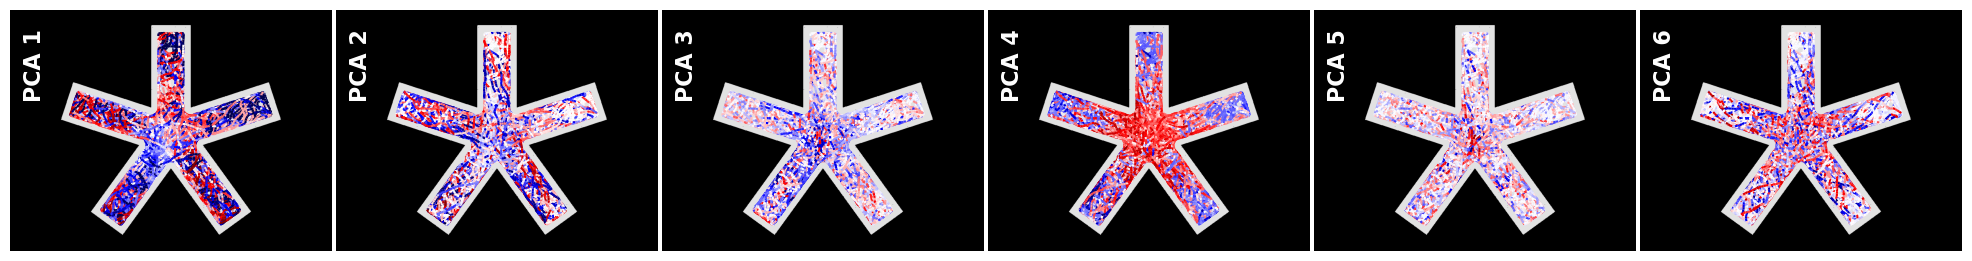

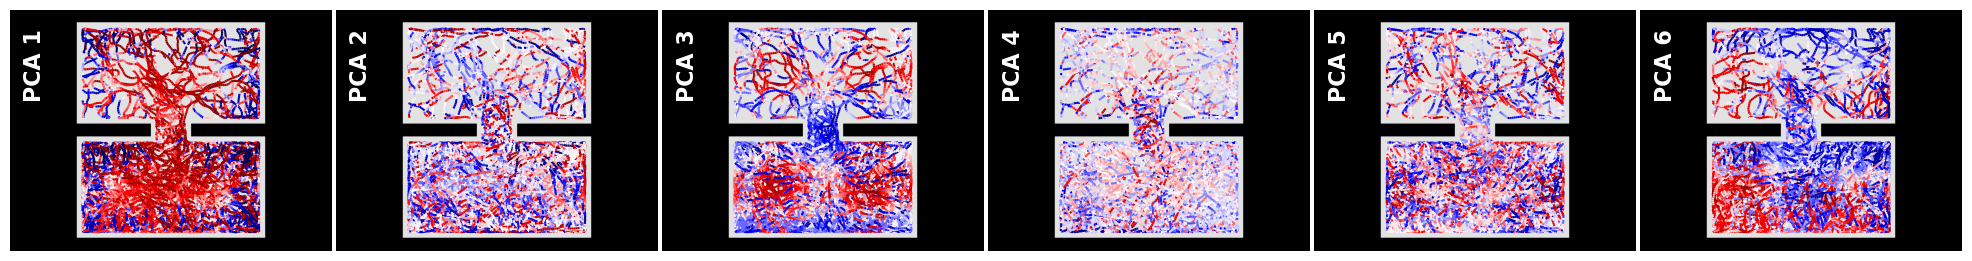

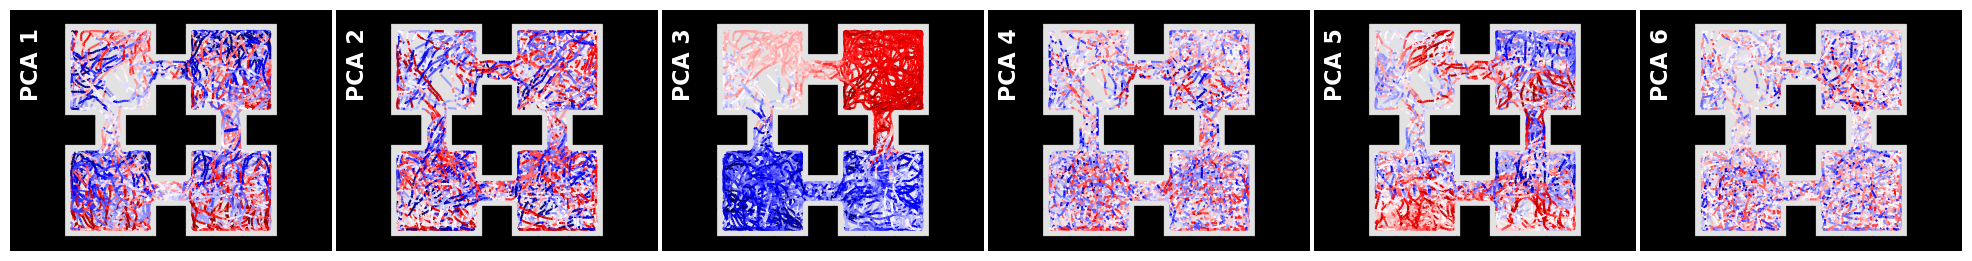

In [11]:
# Plot locations
for i, (env_name, suffix) in enumerate(zip(env_names, suffices)):
    pca_data = pca_datasets[i]
    pos_data = pos_datasets[i]
    fig, axes = plt.subplots(1, 6, figsize = (20,3.3))
    extents, view = generate_top_view(env = env_name, mode = "bg")
    for j in range(6):
        ax = axes[j]#[j//3][j%3]
        visualize_positions(pos_data,
                            view,
                            extents,
                            line=True,
                            colors=pca_data[:,j],
                            ax=ax)
        ax.set_axis_off()
        match suffix:
            case "starmaze":
                x=-9
                y=2.3
            case "wallgap":
                x=-11
                y=2.5
            case "fourcoloredrooms":
                x=-10
                y=2.3
                
        ax.text(x=x, y=y, s=f"PCA {j+1}", c="w", rotation=90, fontsize=16, fontweight="bold")
    fig.tight_layout(h_pad=0.2, w_pad=0.2) # pad = 1.12
    #fig.savefig(f'../images/pca_reps_{suffix}.svg', bbox_inches='tight', format = 'svg', dpi=300) # bbox_inches='tight'
    fig.savefig(f'../images/pca_reps_{suffix}.pdf', bbox_inches='tight')
    fig.savefig(f'../images/pca_reps_{suffix}.png', bbox_inches='tight', format = 'png', dpi=100)
    plt.show()
    plt.close()

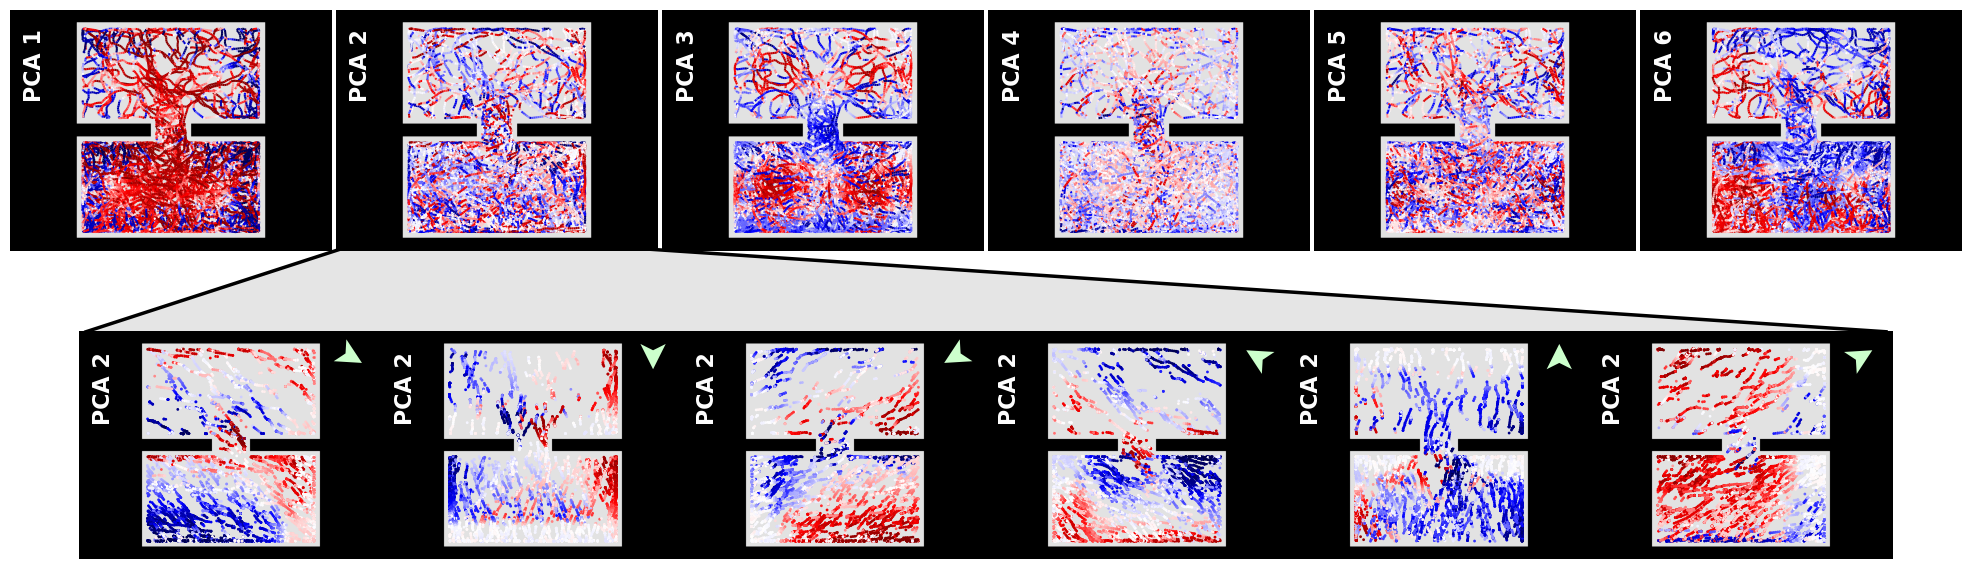

In [35]:
# Plot directions for WallGap|PCA 1
env_num = 1
pca_feature_num = 1
# When adjusting pca_feature_num, you must manually adjust zoom_coords for the zoom polygon to point to the right feature!

pca_data = pca_datasets[env_num]
pos_data = pos_datasets[env_num]
rot_data = rot_datasets[env_num]
fig, axes = plt.subplots(2, 6, figsize = (20,7.5), gridspec_kw = {'height_ratios':[2.4,1]})

extents, view = generate_top_view(env = env_names[env_num], mode = "bg")
arrow = np.array([[8.5,8], [10.5,7], [8.5,6], [9, 7]])
rot_factor = np.pi/3

for j in range(6):
    ax = axes[0][j]
    ax.set_axis_off()
    visualize_positions(pos_data,
                        view,
                        extents,
                        line=True,
                        colors=pca_data[:,j],
                        ax=ax)
    x=-11
    y=2.5
    ax.text(x=x, y=y, s=f"PCA {j+1}", c="w", rotation=90, fontsize=16, fontweight="bold")

    ax = axes[1][j]
    ax.set_axis_off()
    idxs = np.where((rot_data > rot_factor*j) & (rot_data <= rot_factor*(j+1)))[0]
    positions = np.take(pos_data, idxs, axis=0)
    colors = np.take(pca_data[:,pca_feature_num], idxs, axis=0)
    visualize_positions(positions, view, extents, line=False, colors=colors, ax=ax)
    y = 2
    ax.text(x=x, y=y, s=f"PCA {pca_feature_num+1}", c="w", rotation=90, fontsize=16, fontweight="bold")

    rot_deg = -(rot_factor*j + rot_factor/2)*360/2/np.pi
    arrow_patch = mpl.patches.Polygon(arrow, transform=Affine2D().rotate_deg_around(*(9.5,7), rot_deg)+ax.transData, fc=(0.8,1,0.8),zorder=99)
    ax.add_patch(arrow_patch)
        
fig.tight_layout(h_pad=1, w_pad=0.2) # pad = 1.12

move_by = [0.03, 0.018, 0.006, -0.006, -0.018, -0.03]
for i in range(6):
    pos = axes[1, i].get_position()
    new_pos = [pos.x0+move_by[i], pos.y0, pos.width, pos.height]
    axes[1, i].set_position(new_pos)

zoom_offsets = [0, 0.177, 0, 0.505, 0, 0]
zoom_coords = np.array([[0.05,0.335], [zoom_offsets[pca_feature_num],0.445], [zoom_offsets[pca_feature_num]+0.155,0.445], [0.95,0.335]])
zoom = mpl.patches.Polygon(zoom_coords, fc=(0,0,0,0.1), ec=(0,0,0,0.4), linewidth=2.5, zorder=99)
polygon = mpl.patches.Polygon(zoom_coords, fc=(0,0,0,0.1), ec=(0,0,0,0), zorder=99) #linewidth=2.5
line1 = mpl.lines.Line2D(zoom_coords[0:2,0], zoom_coords[0:2,1], c=(0,0,0,1), linewidth=2.5, zorder=99)
line2 = mpl.lines.Line2D(zoom_coords[2:4,0], zoom_coords[2:4,1], c=(0,0,0,1), linewidth=2.5, zorder=99)
fig.add_artist(polygon)
fig.add_artist(line1)
fig.add_artist(line2)
#fig.savefig(f'../images/pca_reps_{suffices[env_num]}_with_rot.svg', bbox_inches='tight', format = 'svg', dpi=300) # bbox_inches='tight'
# fig.savefig(f'../images/pca_reps_{suffices[env_num]}_with_rot.pdf', bbox_inches='tight')
# fig.savefig(f'../images/pca_reps_{suffices[env_num]}_with_rot.png', bbox_inches='tight', format = 'png', dpi=100)
plt.show()
plt.close()

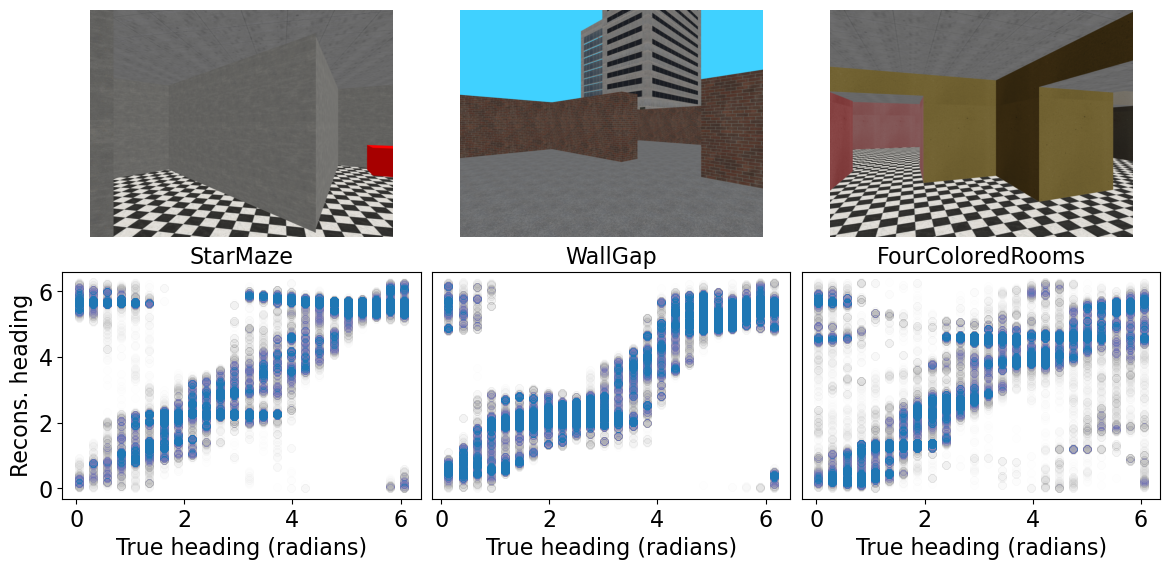

In [30]:
# Render high-res environment views and plot headings
n_train_subset = int(len(pca_datasets[0])*0.5)

env_names = ['MiniWorld-StarMazeArm-v0',
             'MiniWorld-WallGapEmpty-v0',
             'MiniWorld-FourColoredRoomsEmpty-v0',]

fig, axes = plt.subplots(2, 3, figsize = (12,6))

for i, (env_name, suffix) in enumerate(zip(env_names, suffices)):
    ax = axes[0][i]
    env = gym.make(env_name, view="agent", render_mode="rgb_array", obs_width=10*80, obs_height=10*60)
    obs, info = env.reset()
    match suffix:
        case "starmaze":
            env.agent.pos = [-0.9492, 0, -1.0658]
            env.agent.dir = 0.2009
            title = "StarMaze"
        case "wallgap":
            env.agent.pos = [-3.6325, 0, -6.1611]
            env.agent.dir = 5.5
            title = "WallGap"
        case "fourcoloredrooms":
            env.agent.pos = [-6.1617, 0, -3.3271]
            env.agent.dir = -0.35
            title = "FourColoredRooms"
    obs = env.render()
    ax.imshow(obs)
    ax.set_axis_off()
    
    ax = axes[1][i]
    pca_data = pca_datasets[i]
    rot_data = rot_datasets[i]
    reg_cos = LinearRegression().fit(pca_data[:n_train_subset],
                                     np.cos((rot_data[:n_train_subset])%(2*np.pi)-np.pi))
    reg_sin = LinearRegression().fit(pca_data[:n_train_subset],
                                     np.sin((rot_data[:n_train_subset])%(2*np.pi)-np.pi))

    predicted_cos = reg_cos.predict(pca_data[n_train_subset:])
    predicted_sin = reg_sin.predict(pca_data[n_train_subset:])
    
    
    reconstructed_angles = np.arctan2(predicted_sin, predicted_cos)
    ax.scatter(rot_data[n_train_subset:], reconstructed_angles+np.pi, alpha=0.005)
    ax.set_xlabel("True heading (radians)")
    ax.set_title(title)
    if i==0:
        ax.set_ylabel("Recons. heading")
    else:
        ax.get_yaxis().set_visible(False)
    del env
fig.tight_layout(pad=1.12, h_pad=0.5, w_pad=0.3)
#fig.savefig(f'../images/renderings_and_heading_pca.svg', format = 'svg', dpi=300)
fig.savefig(f'../images/renderings_and_heading_pca.pdf')
fig.savefig(f'../images/renderings_and_heading_pca.png', format = 'png', dpi=100)
plt.show()
plt.close()

In [35]:
fs = 20
plt.rcParams.update({
    'font.size': fs,
    'axes.titlesize': fs,
    'axes.labelsize': fs,
    'legend.fontsize': fs
})

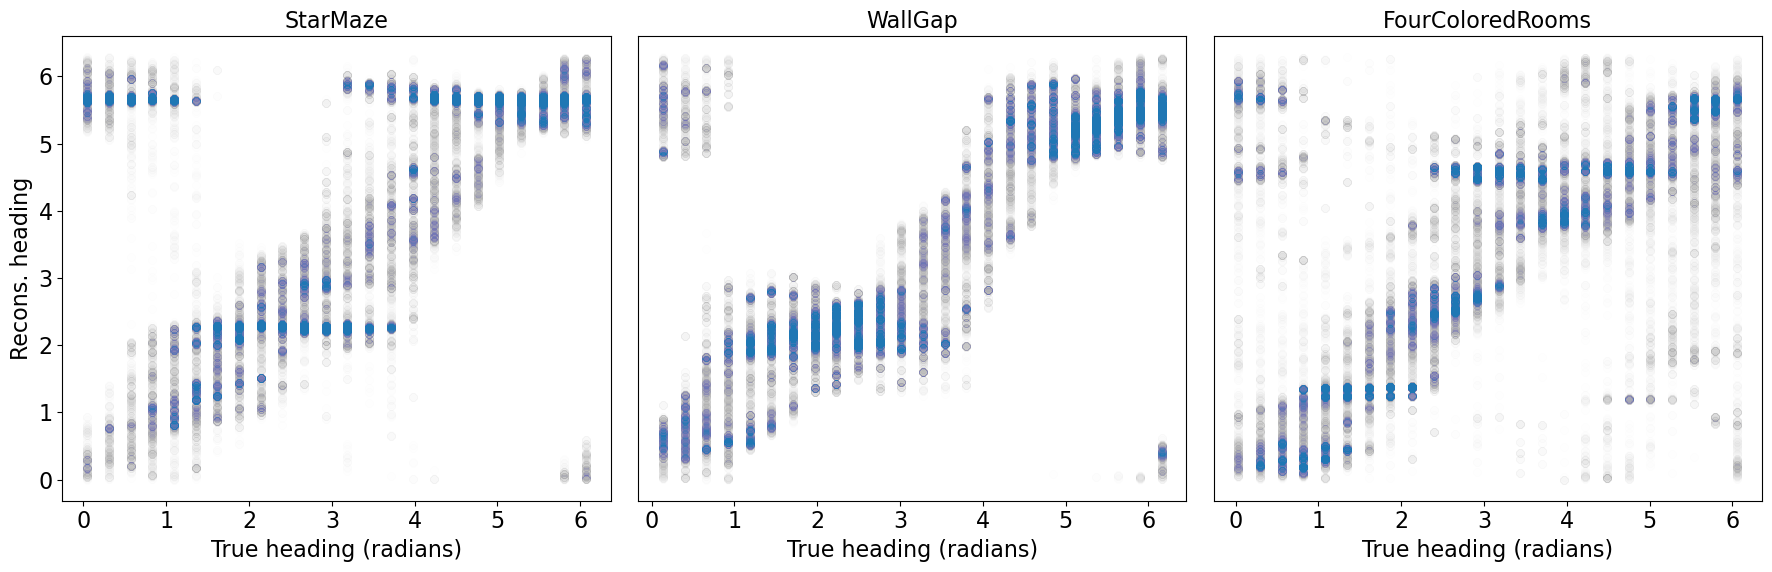

In [32]:
# Plot headings
n_train_subset = int(len(pca_datasets[0])*0.5)

fig, axes = plt.subplots(1, 3, figsize = (18,6))

for i, (env_name, suffix) in enumerate(zip(env_names, suffices)):
    match suffix:
        case "starmaze":
            title = "StarMaze"
        case "wallgap":
            title = "WallGap"
        case "fourcoloredrooms":
            title = "FourColoredRooms"
    ax = axes[i]
    pca_data = pca_datasets[i]
    rot_data = rot_datasets[i]
    reg_cos = LinearRegression().fit(pca_data[:n_train_subset],
                                     np.cos((rot_data[:n_train_subset])%(2*np.pi)-np.pi))
    reg_sin = LinearRegression().fit(pca_data[:n_train_subset],
                                     np.sin((rot_data[:n_train_subset])%(2*np.pi)-np.pi))

    predicted_cos = reg_cos.predict(pca_data[n_train_subset:])
    predicted_sin = reg_sin.predict(pca_data[n_train_subset:])
    
    
    reconstructed_angles = np.arctan2(predicted_sin, predicted_cos)
    ax.scatter(rot_data[n_train_subset:], reconstructed_angles+np.pi, alpha=0.005)
    ax.set_xlabel("True heading (radians)")
    ax.set_title(title)
    if i==0:
        ax.set_ylabel("Recons. heading")
    else:
        ax.get_yaxis().set_visible(False)
fig.tight_layout(h_pad=1, w_pad=1)
#fig.savefig(f'../images/pca_reps_heading.svg', bbox_inches='tight', format = 'svg', dpi=300)
fig.savefig(f'../images/pca_reps_heading.pdf')
fig.savefig(f'../images/pca_reps_heading.png', bbox_inches='tight', format = 'png', dpi=100)
plt.show()
plt.close()